# HDBSCAN Clustering for RBD sequences
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py
--- 
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.dates as mdates

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Merging the metadata with the sequence data.

In [2]:
data_dir = "../../data/rbd"

csv_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv")
df = pd.read_csv(csv_file, header=0, low_memory=False)
df

seq_id                                           sequence  \
0        EPI_ISL_5120698  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
1        EPI_ISL_5123727  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
2       EPI_ISL_14904955  RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...   
3        EPI_ISL_5119677  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
4       EPI_ISL_14904971  RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...   
...                  ...                                                ...   
347427  EPI_ISL_14903692  RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...   
347428  EPI_ISL_14902388  RVQPTESIVRFPNITNLCPFDEVFNATTFASVYAWNRKRISNCVAD...   
347429  EPI_ISL_14905423  RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...   
347430   EPI_ISL_5123715  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
347431  EPI_ISL_14894617  RVQPTESIVRFPNITNLCPFDEVFNATIFASVYAWNRKRISNCVAD...   

        variant  
0         Delta  
1         Delta  
2       Omicron  
3         Delta  
4       Omicron  
...         ...  
347427  Omicron  
347428  Omicron  
347429  Omicron  
347430    Delta  
347431  Omicron  

[347432 rows x 3 columns]

In [3]:
meta_data = os.path.join(data_dir, f"original/spikeprot0528.clean.uniq.noX.RBD.metadata.tsv")
metadata_df = pd.read_csv(meta_data, sep='\t', header=0, low_memory=False)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})
metadata_df = metadata_df[['seq_id', 'Pango lineage', 'Location', 'Collection date', 'AA Substitutions']]

merged_df = pd.merge(df, metadata_df, on='seq_id', how='left')

print(merged_df['variant'].value_counts())
merged_df.head(5)

variant
Omicron    160016
Delta      109448
UNKNOWN     40917
Alpha       22075
Gamma        5978
Iota         2044
Epsilon      1915
Beta         1342
Lambda        985
Mu            939
Eta           611
Zeta          578
Kappa         505
GH/490R        57
Theta          22
Name: count, dtype: int64


seq_id                                           sequence  \
0   EPI_ISL_5120698  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
1   EPI_ISL_5123727  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
2  EPI_ISL_14904955  RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...   
3   EPI_ISL_5119677  RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...   
4  EPI_ISL_14904971  RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...   

   variant Pango lineage                           Location Collection date  \
0    Delta     B.1.617.2          Europe / Germany / Berlin      2021-10-06   
1    Delta          AY.4  Europe / United Kingdom / England      2021-10-08   
2  Omicron        BA.5.5     North America / USA / Maryland      2022-08-22   
3    Delta        AY.126    Europe / Germany / Lower Saxony      2021-09-30   
4  Omicron        BA.5.6   North America / USA / California      2022-08-22   

                                    AA Substitutions  
0  (NSP1_V54del,NSP3_A1321del,N_G215C,NSP3_S1314d...  
1  (N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M...  
2  (NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d...  
3  (N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S...  
4  (NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d...

In [4]:
ado_df = merged_df[merged_df['variant'].isin(["Alpha", "Delta", "Omicron"])]
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
ado_df.to_csv(save_as, index=False)
ado_df['variant'].value_counts()

variant
Omicron    160016
Delta      109448
Alpha       22075
Name: count, dtype: int64

Making the parquet.

In [7]:
# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        self.df = pd.read_csv(csv_file, header=0, na_filter=False)
        self.max_sequence_length = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["Pango lineage"],
            self.df.iloc[idx]["Location"],
            self.df.iloc[idx]["Collection date"],
            self.df.iloc[idx]["AA Substitutions"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class ESM(nn.Module):
    def __init__(self, esm):
        super().__init__()
        self.esm = esm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            last_hidden_states = self.esm(**tokenized_seqs).last_hidden_state # shape: (batch_size, sequence_length, embedding_dim)
            cls_embedding = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)
        return cls_embedding

def run_model(model, tokenizer, dataloader, device, csv_file):   
    """ Call the ESM model to generate hidden states and store batch data in DataFrame directly. """
    
    model = model.to(device)
    model.eval()

    # Set the tqdm progress bar
    data_iter = tqdm.tqdm(enumerate(dataloader),
                          total = len(dataloader),
                          bar_format='{l_bar}{r_bar}')

    batch_dataframes = []

    for _, batch_data in data_iter:
        seq_ids, variants, pango_lineages, locations, collection_dates, aa_subs, sequences = batch_data 

        # Add 2 to max_length to account for additional tokens added to beginning and end by ESM
        max_length = dataloader.dataset.max_sequence_length + 2
        tokenized_seqs = tokenizer(sequences, return_tensors='pt', padding='max_length', max_length=max_length).to(device) 
        
        with torch.no_grad():
            embeddings = model(tokenized_seqs) # shape: [batch_size, sequence_len, embedding_dim]

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "Pango lineage": pango_lineages,
            "Location": locations,
            "Collection date": collection_dates,
            "AA Substitutions": aa_subs,
            "embedding": [embedding.cpu().numpy() for embedding in embeddings]  # Convert tensor to numpy array for each embedding
        })

        batch_dataframes.append(batch_df)

    # Concatenate all batch DataFrames into one
    result_df = pd.concat(batch_dataframes, ignore_index=True)
    
    # Save data to a Parquet file
    save_as = csv_file.replace(".csv", "_CLS-embedded.parquet")
    save_as = save_as.replace("/data/rbd", "/data/rbd/parquets/embeddings")
    result_df.to_parquet(save_as, index=False)
    print(f"Data saved to {save_as}")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# Data file
data_dir = "../../data/rbd"
csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
dataset = RBDDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# ESM input
esm_version = "facebook/esm2_t6_8M_UR50D"
esm = EsmModel.from_pretrained(esm_version, cache_dir='../model_downloads').to(device)
tokenizer = AutoTokenizer.from_pretrained(esm_version, cache_dir='../model_downloads')

model = ESM(esm)
run_model(model, tokenizer, dataloader, device, csv_file)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|| 4556/4556 [05:32<00:00, 13.69it/s]


Data saved to ../../data/rbd/parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet


---

### Clustering - tSNE, then HDBSCAN
Sampling from the embeddings.

In [4]:
parquet_file = os.path.join(data_dir, "parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
print(sampled_ado_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed{rnd_seed}.parquet")
sampled_ado_df.to_parquet(save_as, index=False)

variant
Alpha      22075
Delta      22075
Omicron    22075
Name: count, dtype: int64


Apply tSNE to the embeddings, then save the tSNE embeddings. I used 1% of the data to set the perplexity for this large dataset (>10,000): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6882829/.

In [ ]:
# Load in the data
parquet_file = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_ado_df["embedding"])
info_df = embedded_ado_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix, took ~ 13 min
perplexity = round(len(info_df) * 0.01) 
print(perplexity)
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

662


Load in the tSNE embeddings.

In [5]:
# Load the embedding
data_dir = "../../data/rbd"
perplexity = 662
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne-perp{perplexity}.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_ado_df[['DIM_1', 'DIM_2']].values
info_df = embedded_ado_df.drop(columns=['DIM_1', 'DIM_2'])

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

In [8]:
for i in [100, 1000, 1500, 2000]:
    for j in [1000, 10000, 15000, 20000, 21000, 22000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 100, min_cluster_size 1000: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.48)
min_sample 100, min_cluster_size 10000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 15000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 20000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 21000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 22000: (Silhouette Coefficient 0.51, Adjusted Rand Index 0.55)
min_sample 1000, min_cluster_size 1000: (Silhouette Coefficient 0.60, Adjusted Rand Index 0.58)
min_sample 1000, min_cluster_size 10000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 15000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 20000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 2100

Plotting the tSNE embeddings after applying HDBSCAN.

In [3]:
def plot_hdbscan_comparison(save_as, info_df, embedding_matrix, hdb_labels, data_column, colormap):   
    # Ground truth color mapping
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette(colormap, n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # HDBSCAN cluster color mapping
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fontsize = 20

    # Left subplot: Ground Truth
    ax1 = axes[0]
    ax1.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=fontsize)
    for value in unique_data_values:
        mask = info_df[data_column] == value
        ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[ground_truth_color_dict[value]], label=value,
                    s=20, alpha=0.75)

    ax1.legend(loc='upper left', fontsize=fontsize-6, markerscale=2)

    # Right subplot: HDBSCAN clusters
    ax2 = axes[1]
    ax2.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=fontsize)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=35)
        else:
            ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=20, alpha=0.75)
    ax2.legend(loc='upper left', fontsize=fontsize-6, markerscale=2)

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=fontsize)
        ax.set_ylabel('Component 2', fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    plt.tight_layout()
    plt.savefig(f"{save_as}.pdf", format="pdf")
    plt.savefig(f"{save_as}.png", format="png")
    plt.show()

def plot_hdbscan_predictions(save_as, info_df, embedding_matrix, hdb_labels, data_column, colormap):   
    # HDBSCAN cluster color mapping
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

    plt.figure(figsize=(14, 9))
    fontsize = 20

    # Plot HDBSCAN clusters
    plt.title(f'Predicted: {n_predicted_clusters} clusters', fontsize=fontsize)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            plt.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=35)
        else:
            plt.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=20, alpha=0.75)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize-6, markerscale=2)
    plt.xlabel('Component 1', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Component 2', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"{save_as}.preds_only.pdf", format="pdf")
    plt.savefig(f"{save_as}.preds_only.png", format="png")
    plt.show()

def plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, data_column):
    # Create the truth table
    truth_table_percent = pd.crosstab(info_df[data_column], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100)

    # Plot heatmap
    plt.figure(figsize=(16, 9))
    fontsize = 20
    heatmap = sns.heatmap(truth_table_percent, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": fontsize})
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('Percentage (%)', fontsize=fontsize) 
    plt.title('Ground Truth vs Predicted Clusters', fontsize=fontsize)
    plt.xlabel('Predicted Clusters', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Ground Truth', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".truthtable.pdf", format="pdf")
    plt.savefig(save_as + ".truthtable.png", format="png")
    plt.show()
    
def cluster_date_collected(save_as, info_df, hdb_labels, colormap):
    """ Calculate variant percentages over collection dates within clusters and plot them in a single plot. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Define cluster color mapping, with outliers (Cluster -1) as black
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    # Ensure 'Collection date' is a datetime object
    df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

    # Aggregate data by counting variants for each collection date (by year and month)
    df['YearMonth'] = df['Collection date'].dt.to_period('M')
    cluster_date_counts = df.groupby(['Cluster', 'YearMonth', 'variant']).size().reset_index(name='Cluster count')

    # Calculate total count within each cluster
    total_cluster_count = df.groupby(['Cluster']).size().reset_index(name='Total count')
    cluster_date_counts = cluster_date_counts.merge(total_cluster_count, on='Cluster')

    # Calculate percentages within each cluster
    cluster_date_counts['Cluster %'] = (cluster_date_counts['Cluster count'] / cluster_date_counts['Total count']) * 100

    # Sort by 'Cluster' and 'YearMonth'
    cluster_date_counts = cluster_date_counts.sort_values(by=['Cluster', 'YearMonth'], ascending=[True, True])

    # Create a single plot with all clusters and variants
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot each cluster-variant pair in the same plot, applying color mapping
    for (cluster_label, variant), grouped_df in cluster_date_counts.groupby(['Cluster', 'variant']):
        ax.plot(grouped_df['YearMonth'].dt.to_timestamp(), 
                grouped_df['Cluster %'], 
                label=f"Cluster {cluster_label}",
                color=cluster_color_dict[cluster_label],  # Apply cluster-specific color
                linewidth=3)

    fontsize = 20
    ax.set_xlabel('Collection Date', fontsize=fontsize)
    ax.set_ylabel(f'Percentage (%)', fontsize=fontsize)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.legend(loc='upper right', fontsize=fontsize-6, bbox_to_anchor=(1, 1))

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".timescale.pdf", format="pdf")
    plt.savefig(save_as + ".timescale.png", format="png")
    plt.show()
    

def cluster_pango_lineage(info_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])
    lineage_counts = lineage_counts.drop(columns=['Cluster count', 'Total count'])

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

min_sample 1500, min_cluster_size 21000: Silhouette Coefficient: 0.67, Adjusted Rand Index: 0.97


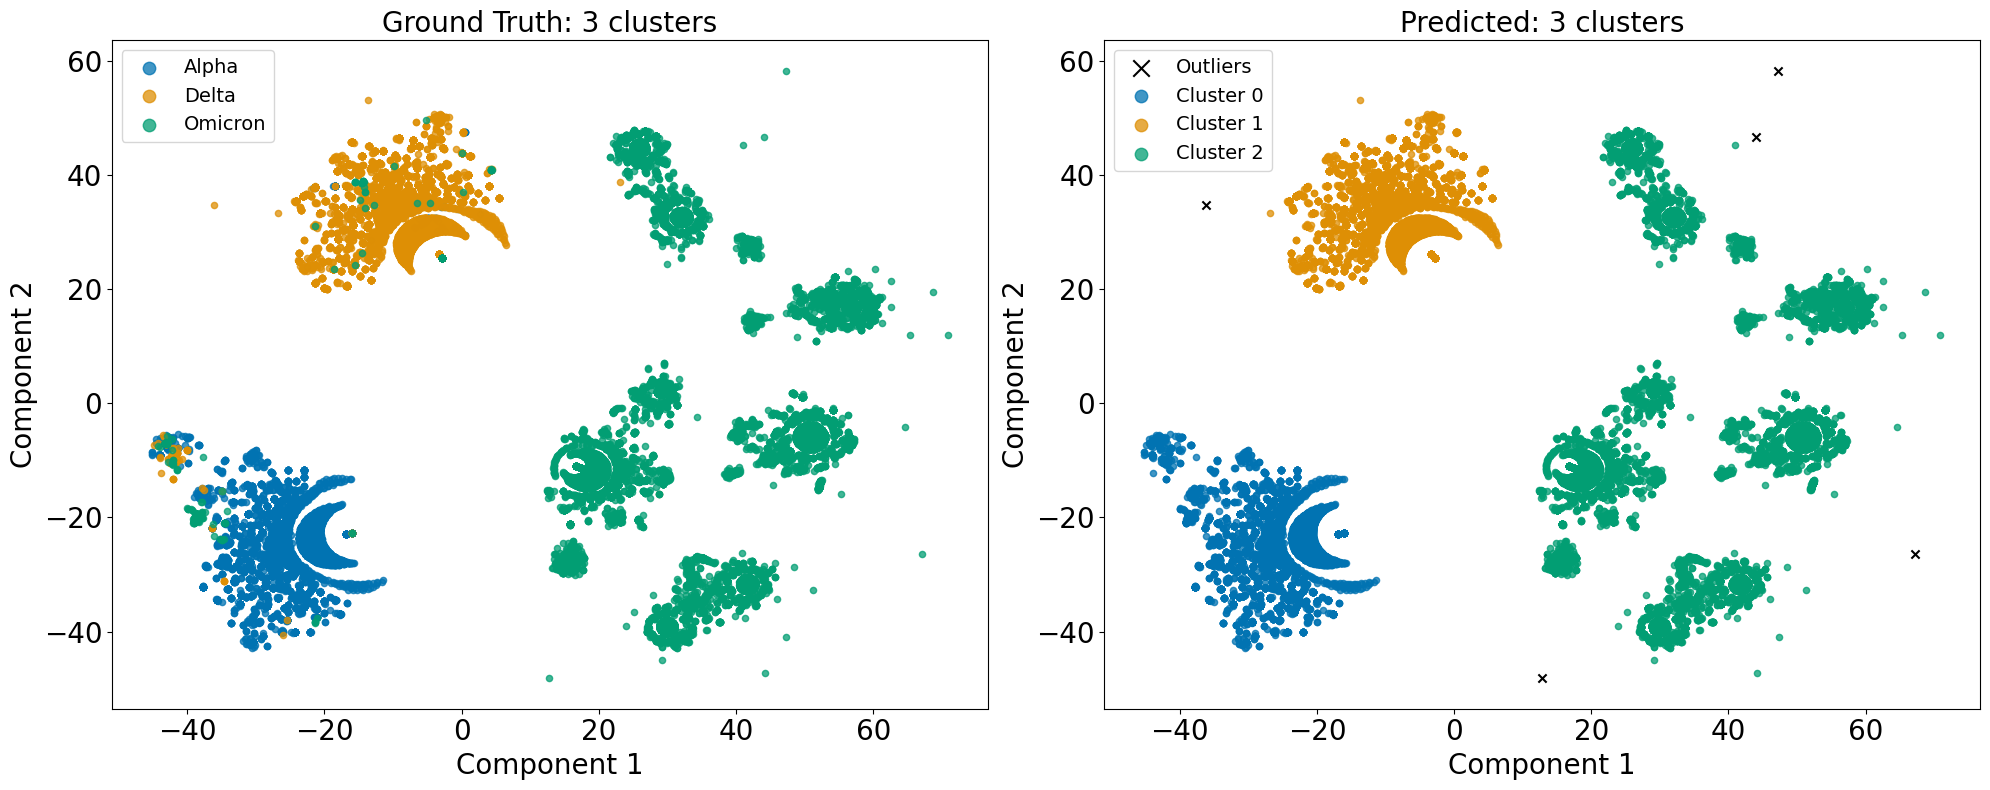

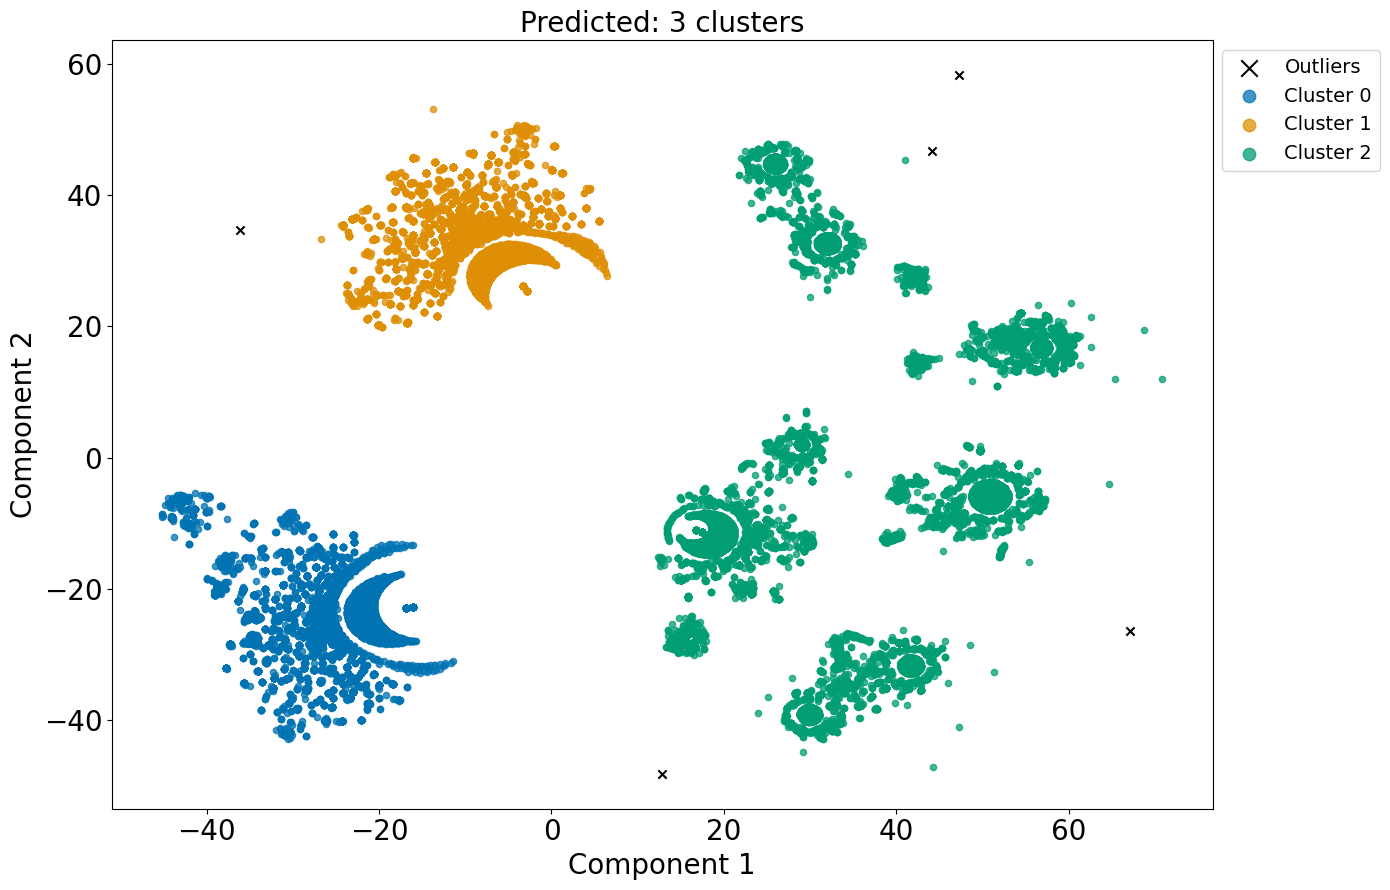

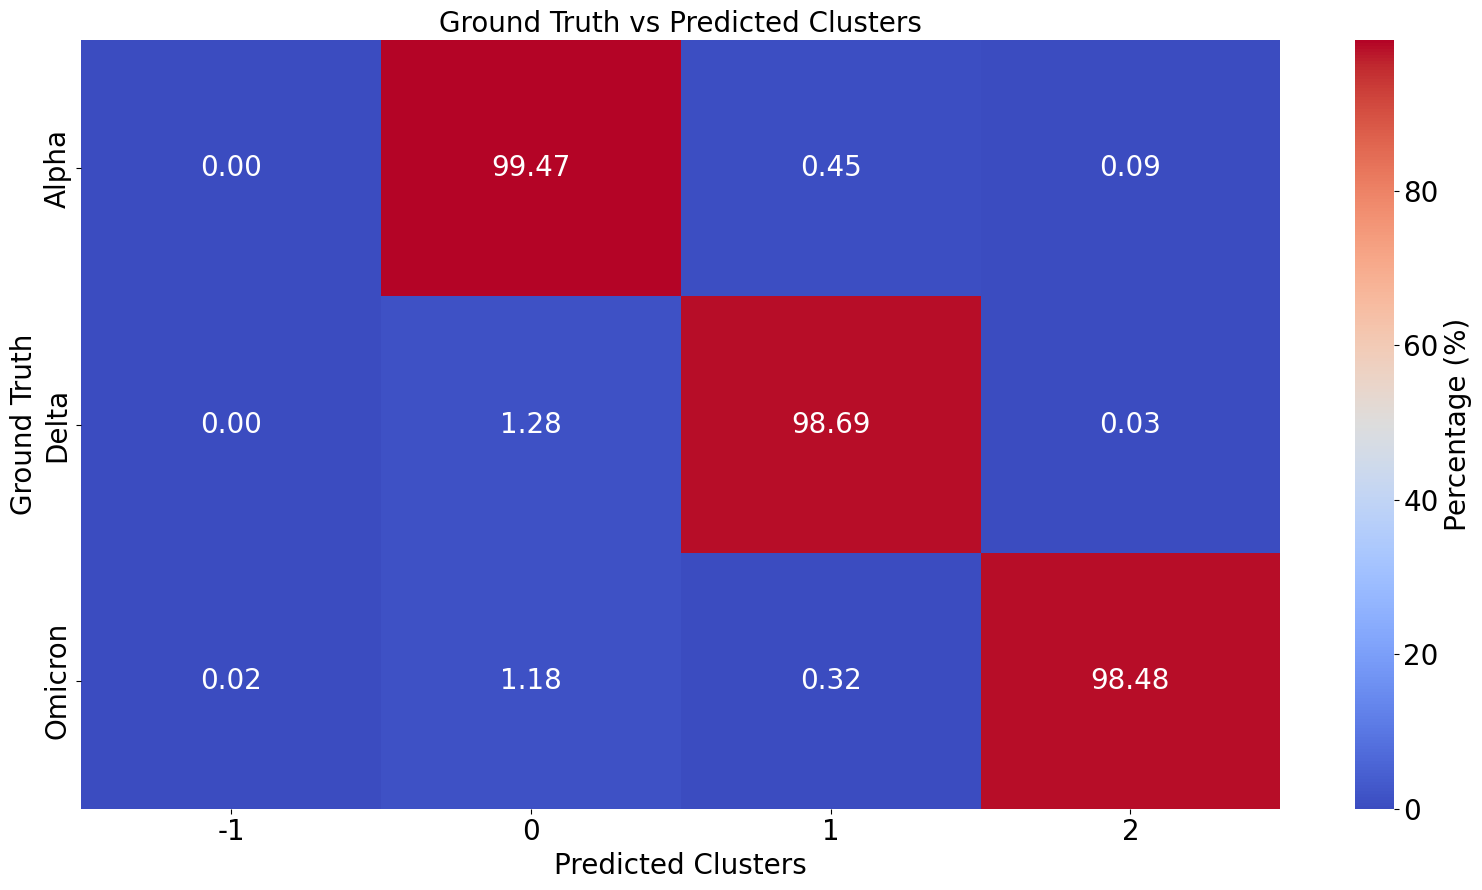

Predicted Clusters  -1      0      1      2
Ground Truth                               
Alpha                0  21957     99     19
Delta                1    283  21785      6
Omicron              4    261     71  21739
   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1    Delta         AY.28       20.0   5.555556
1       -1  Omicron       BA.2.9*       20.0   0.316456
2       -1  Omicron          BF.5       20.0   0.308642
3       -1  Omicron       BQ.1.1*       20.0   0.070077
4       -1  Omicron          BV.1       20.0  25.000000

   Cluster  variant Pango lineage  Cluster %   Lineage %
0        0    Alpha        B.1.1*  95.249100   98.970215
1        0    Alpha           Q.3   0.857740   98.974359
2        0    Alpha           Q.1   0.537754  100.000000
3        0    Alpha           Q.4   0.506644   98.275862
4        0  Omicron    Unassigned   0.324430    8.578143

   Cluster variant Pango lineage  Cluster %  Lineage %
0        1   Delta          AY.4  13.113186  

In [7]:
min_samples=1500
min_cluster_size=21000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.ADO.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_comparison(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")
plot_hdbscan_predictions(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

---
### Omicron only (Downsampled)
Extract the omicron values only

In [8]:
# Load the embedding
data_dir = "../../data/rbd"
perplexity = 662
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne-perp{perplexity}.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedded_ado_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_ado_o_df['variant'].value_counts())

embedding_matrix_reduced = embedded_ado_o_df[['DIM_1', 'DIM_2']].values
info_df = embedded_ado_o_df.drop(columns=['DIM_1', 'DIM_2'])

variant
Omicron    22075
Name: count, dtype: int64


In [95]:
for i in [5, 10, 15, 20, 25, 50, 100, 250, 300, 350, 400, 450, 500, 1000]:
    for j in [500, 1000, 1250, 1500, 2000, 2500, 3000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j, 
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 500: (Silhouette Coefficient 0.29, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 1000: (Silhouette Coefficient 0.33, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 1250: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 1500: (Silhouette Coefficient 0.53, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 2000: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 2500: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 3000: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 500: (Silhouette Coefficient 0.30, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 1000: (Silhouette Coefficient 0.35, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 1250: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 1500: (Silhouette Coefficient 0.62, A

min_sample 300, min_cluster_size 500: Silhouette Coefficient: 0.60, Adjusted Rand Index: 0.00


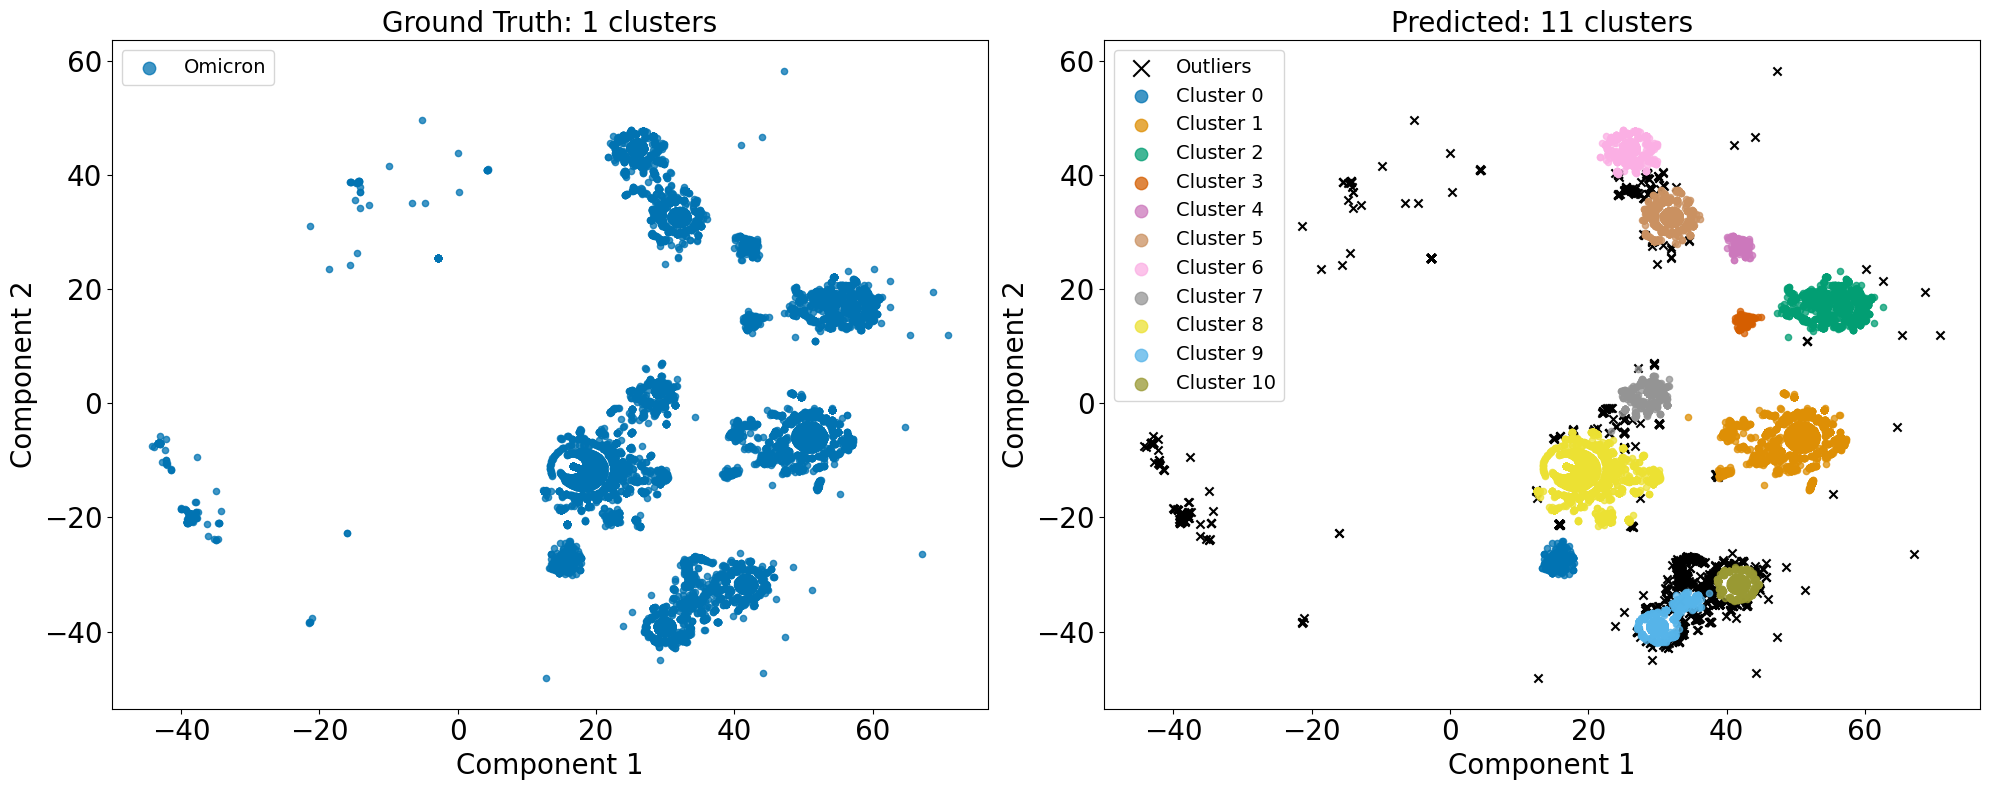

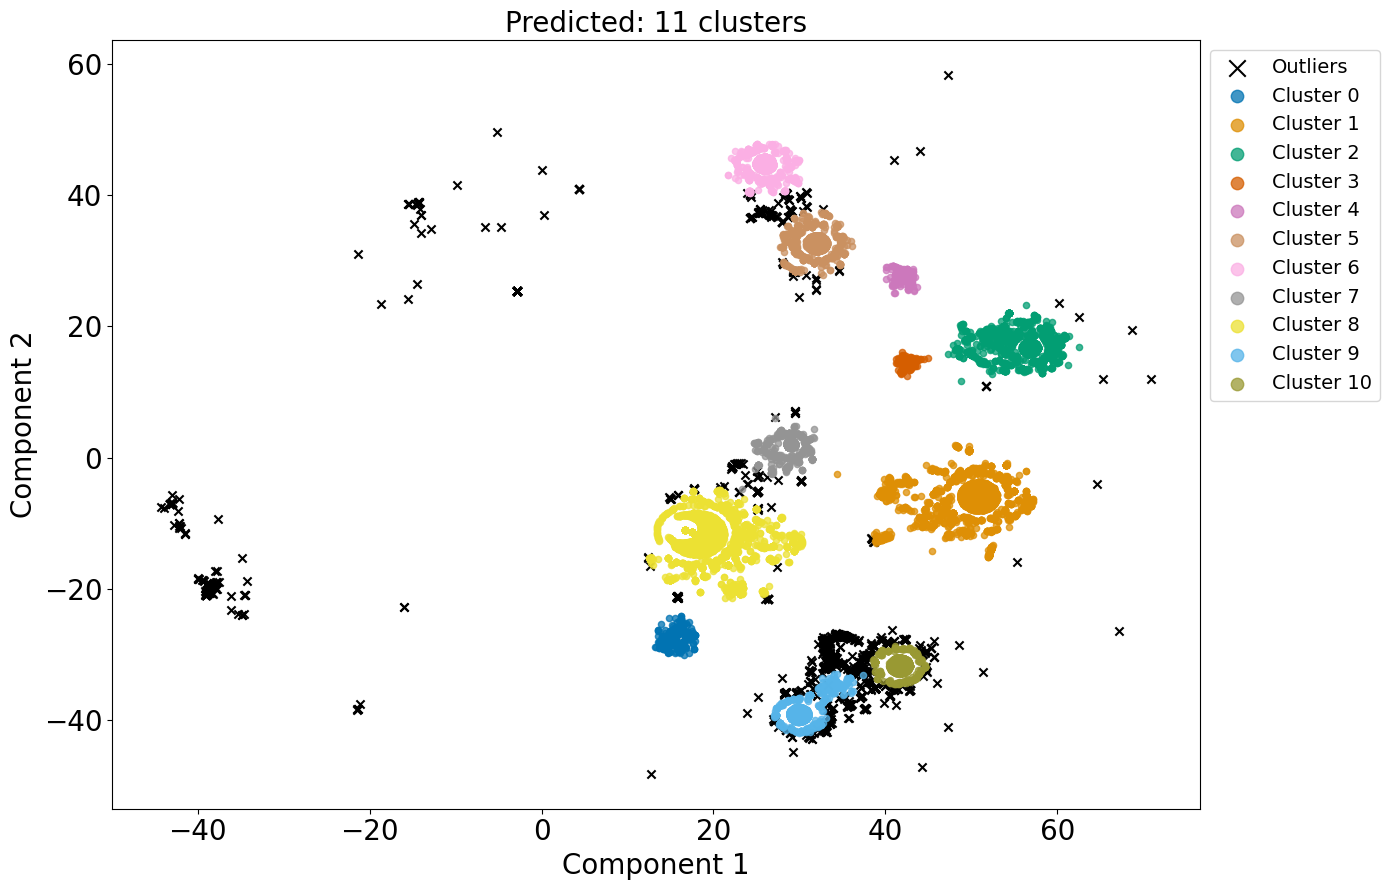

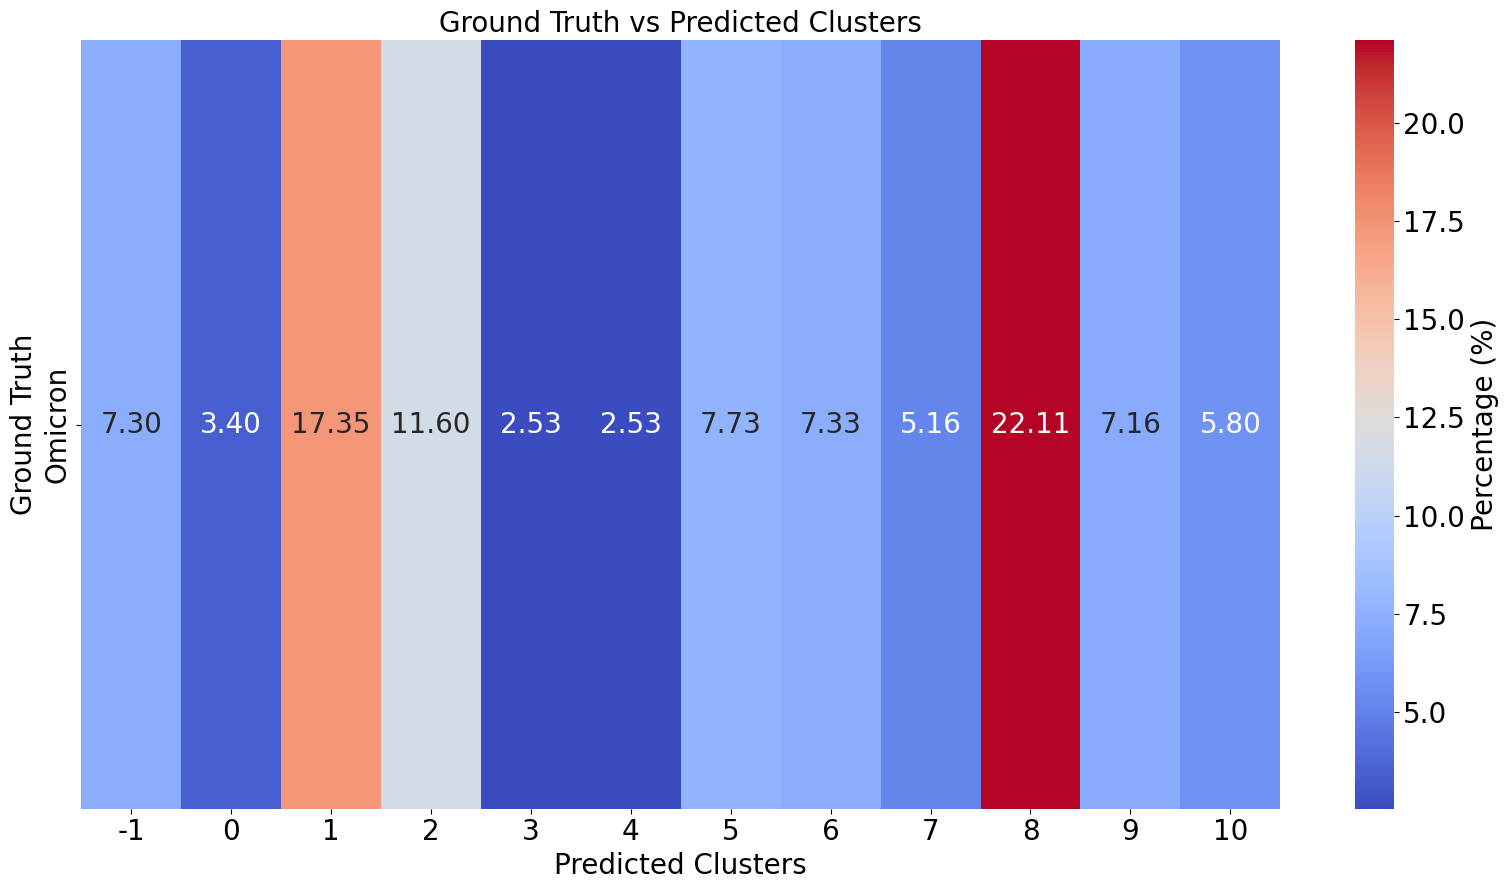

Predicted Clusters   -1    0     1     2    3    4     5     6     7     8   \
Ground Truth                                                                  
Omicron             1612  750  3829  2561  558  559  1706  1619  1139  4881   

Predicted Clusters    9     10  
Ground Truth                    
Omicron             1581  1280  
   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron       BA.1.1*  22.084367  20.215786
1       -1  Omicron          BA.1  14.081886  30.717185
2       -1  Omicron    Unassigned   7.878412  14.923619
3       -1  Omicron          BA.2   7.382134   6.134021
4       -1  Omicron       BA.5.2*   6.575682   5.042816

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      BA.2.12*  81.733333  80.130719
1        0  Omicron          BA.2   3.733333   1.443299
2        0  Omicron       BA.5.2*   2.533333   0.903901
3        0  Omicron       BA.5.1*   1.600000   1.100917
4        0  Omicron    Unassigned   1.600000  

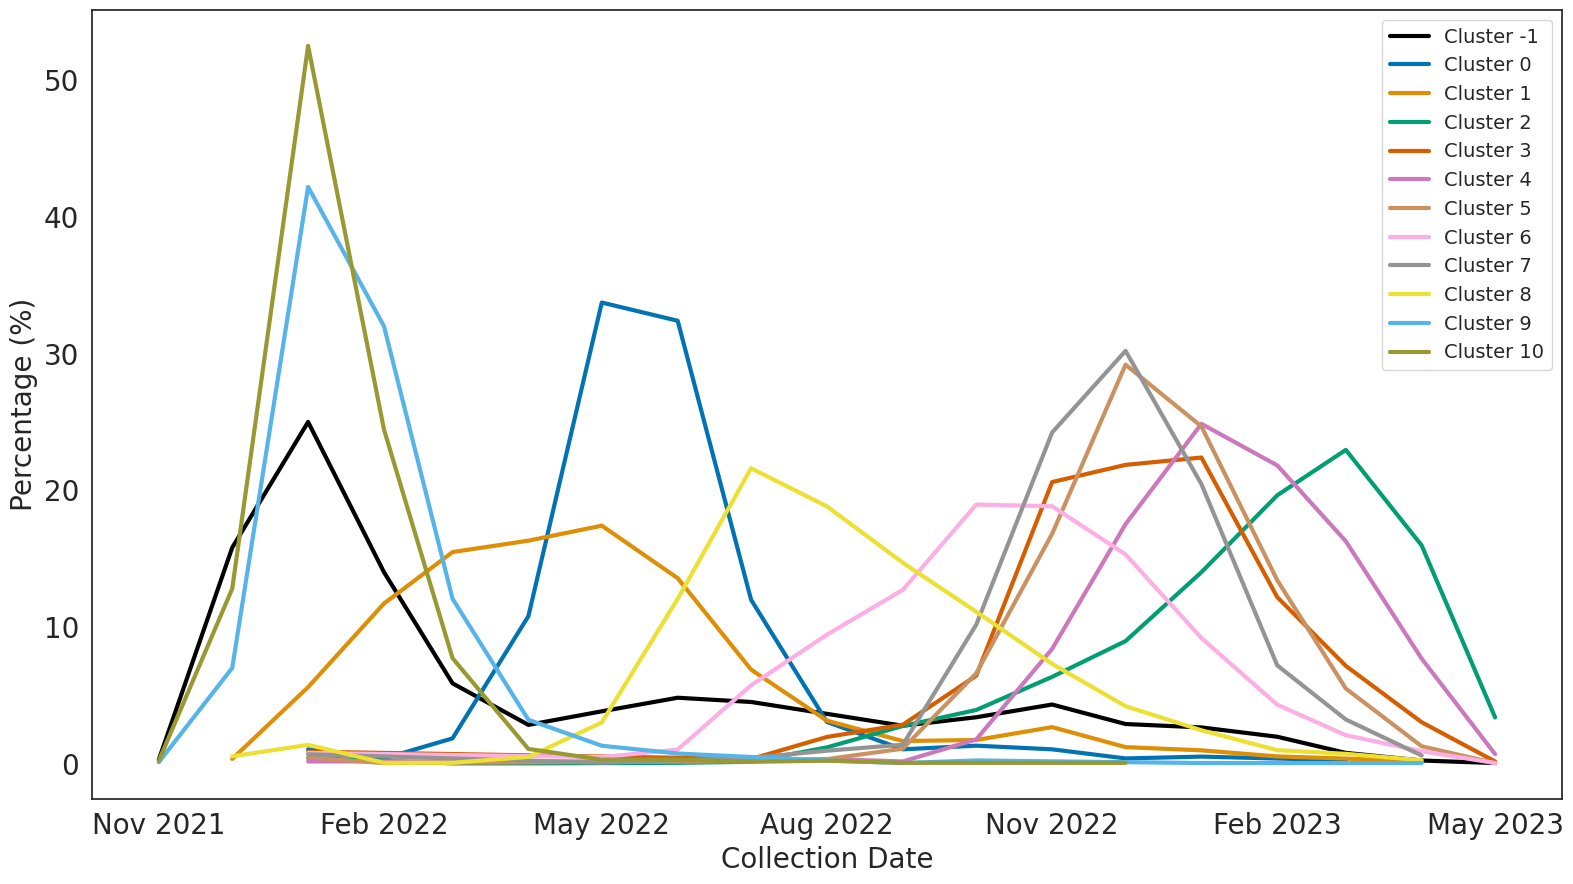

In [9]:
min_samples=300
min_cluster_size=500

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.ADO.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_comparison(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")
plot_hdbscan_predictions(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "colorblind")

Take a look at the clusters and the pango lineages in them (above).
- Cluster %: The percentage of a specific Pango lineage within a particular cluster, calculated as the number of occurrences of that lineage in the cluster divided by the total number of occurrences of all lineages in the cluster.
- Lineage %: The percentage of a specific Pango lineage's occurrences in a cluster relative to its total occurrences across the entire dataset.

Maybe better names would be Lineage Cluster %, Lineage Dataset %?

---
### Omicron only (all available)

In [10]:
data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, "parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Extract Omicron only
embedded_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_o_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df.to_parquet(save_as, index=False)

variant
Omicron    160016
Name: count, dtype: int64


Apply tSNE to the embeddings.

In [63]:
# Load in the data
parquet_file = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_o_df["embedding"])
info_df = embedded_o_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix, took ~  min
perplexity = round(len(info_df) * 0.01)
print(perplexity) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.tsne-perp_{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

1600


Load in the tSNE embeddings.

In [4]:
# Load the embedding
data_dir = "../../data/rbd"
perplexity = 1600
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.tsne-perp_{perplexity}.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_o_df[['DIM_1', 'DIM_2']].values
info_df = embedded_o_df.drop(columns=['DIM_1', 'DIM_2'])

Find the highest Silhouette Coefficient and Adjusted Rand Index.

In [65]:
for i in [100, 150, 200, 225, 250, 500, 750]:
    for j in [1000, 5000, 10000, 12500, 15000, 25000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 100, min_cluster_size 1000: (Silhouette Coefficient 0.30, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 5000: (Silhouette Coefficient 0.40, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 10000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 12500: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 15000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 25000: (Silhouette Coefficient 0.48, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 1000: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 5000: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 10000: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 12500: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 15000: (Sil

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 250, min_cluster_size 15000: Silhouette Coefficient: 0.57, Adjusted Rand Index: 0.00


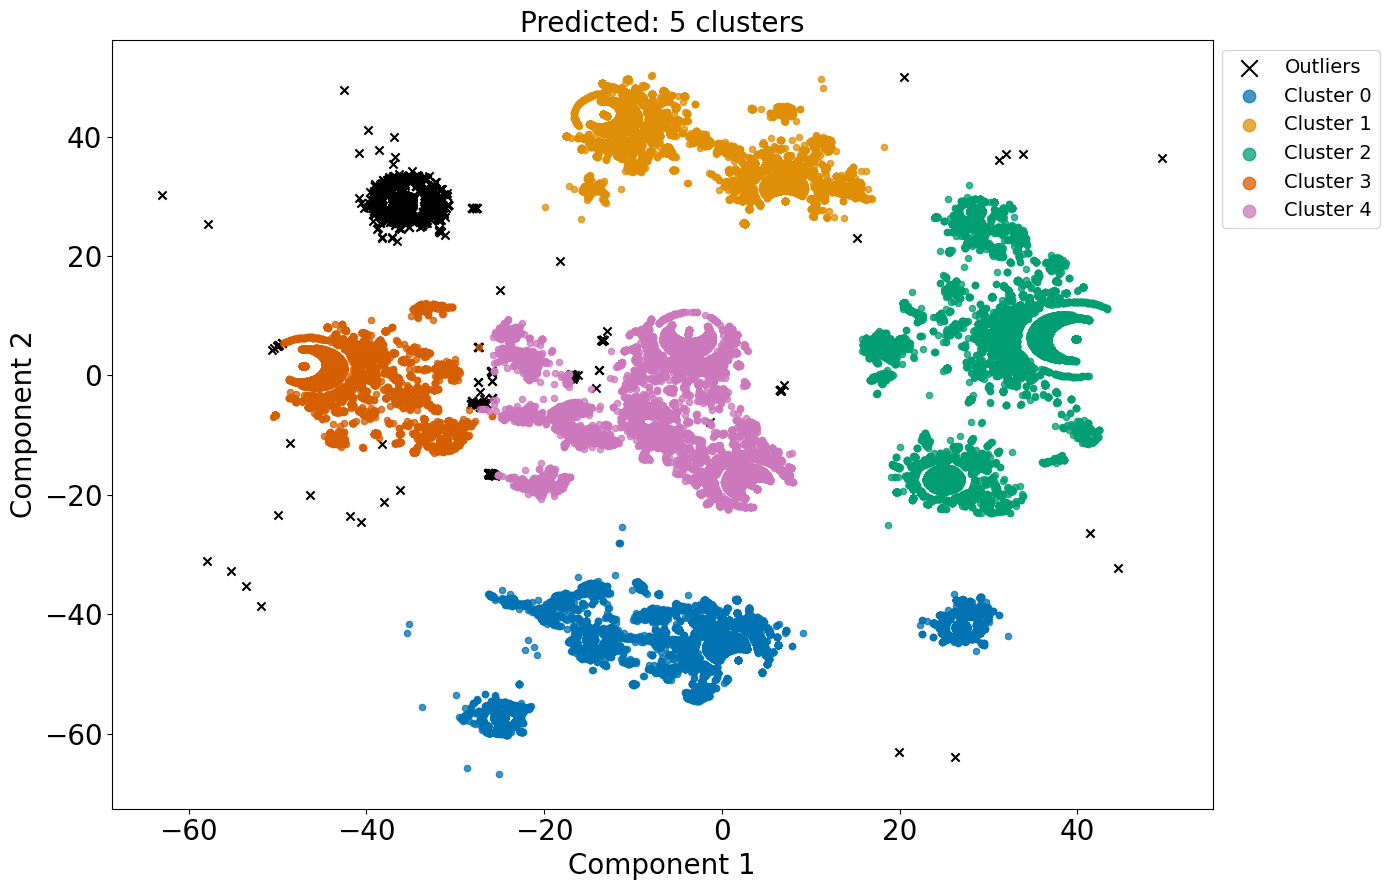

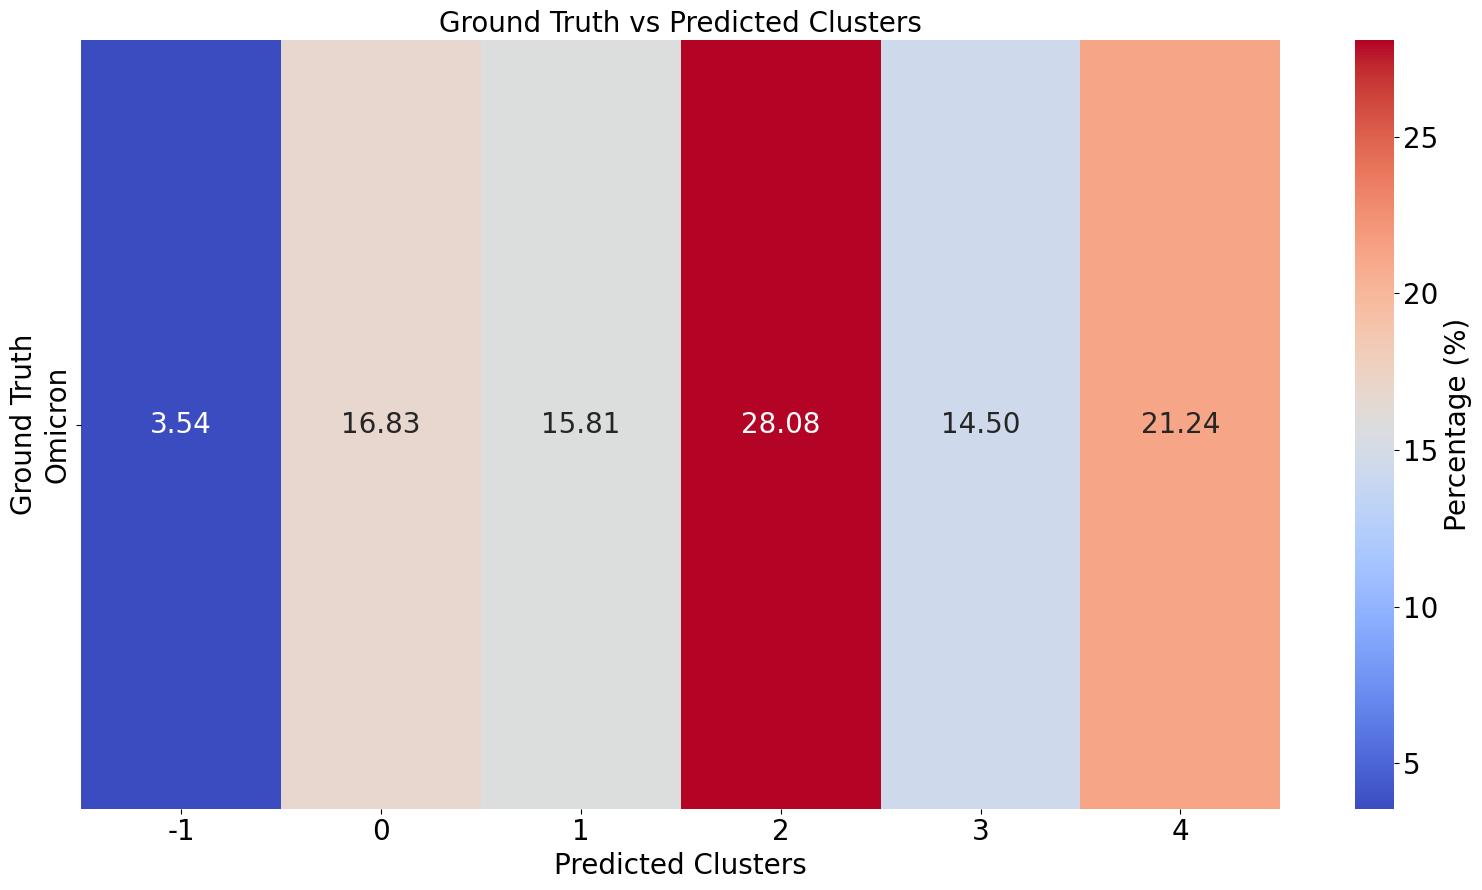

Predicted Clusters    -1      0      1      2      3      4
Ground Truth                                               
Omicron             5672  26932  25299  44930  23199  33984
   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron      BA.2.12*  75.229196  79.921334
1       -1  Omicron          BA.2   5.553597   2.260820
2       -1  Omicron       BA.5.2*   2.997179   1.067370
3       -1  Omicron       BA.5.1*   1.904090   1.414724
4       -1  Omicron    Unassigned   1.763047   1.550147

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      XBB.1.5*  30.198277  99.632488
1        0  Omicron       CH.1.1*   9.702213  99.467073
2        0  Omicron       BN.1.3*   5.094312  99.061372
3        0  Omicron      BA.2.75*   4.470518  95.102686
4        0  Omicron         XBB.1   4.381405  99.578059

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        1  Omicron       BQ.1.1*  41.444326  96.823345
1        1  Omicron       BA.4.6* 

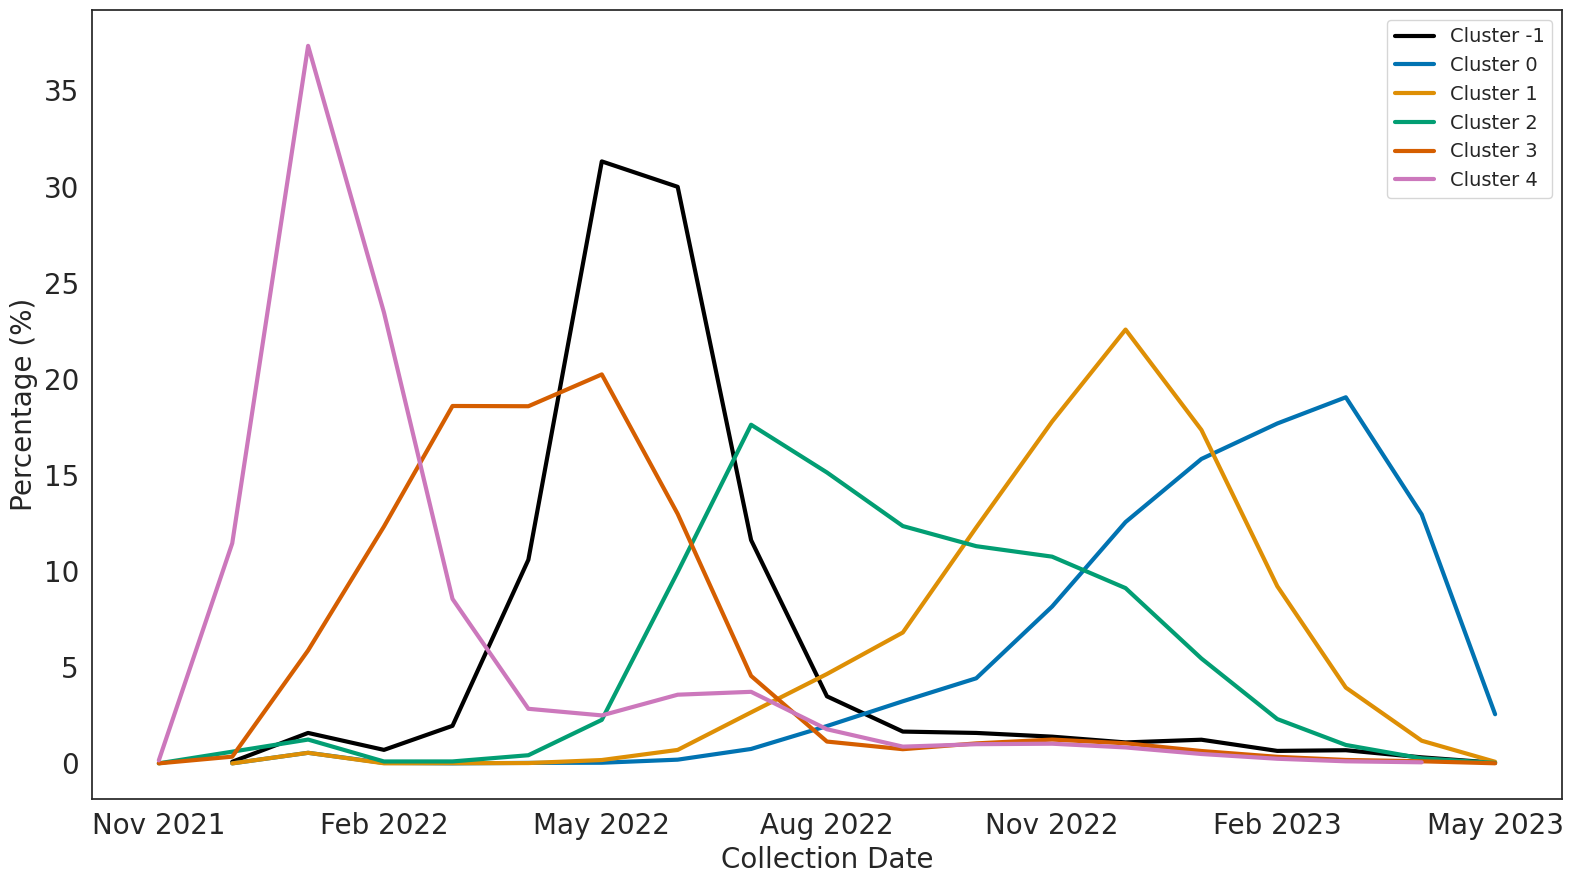

In [5]:
min_samples=250
min_cluster_size=15000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "colorblind")

We'll use the one below since it separates the clusters a little more.

min_sample 250, min_cluster_size 5000: Silhouette Coefficient: 0.43, Adjusted Rand Index: 0.00


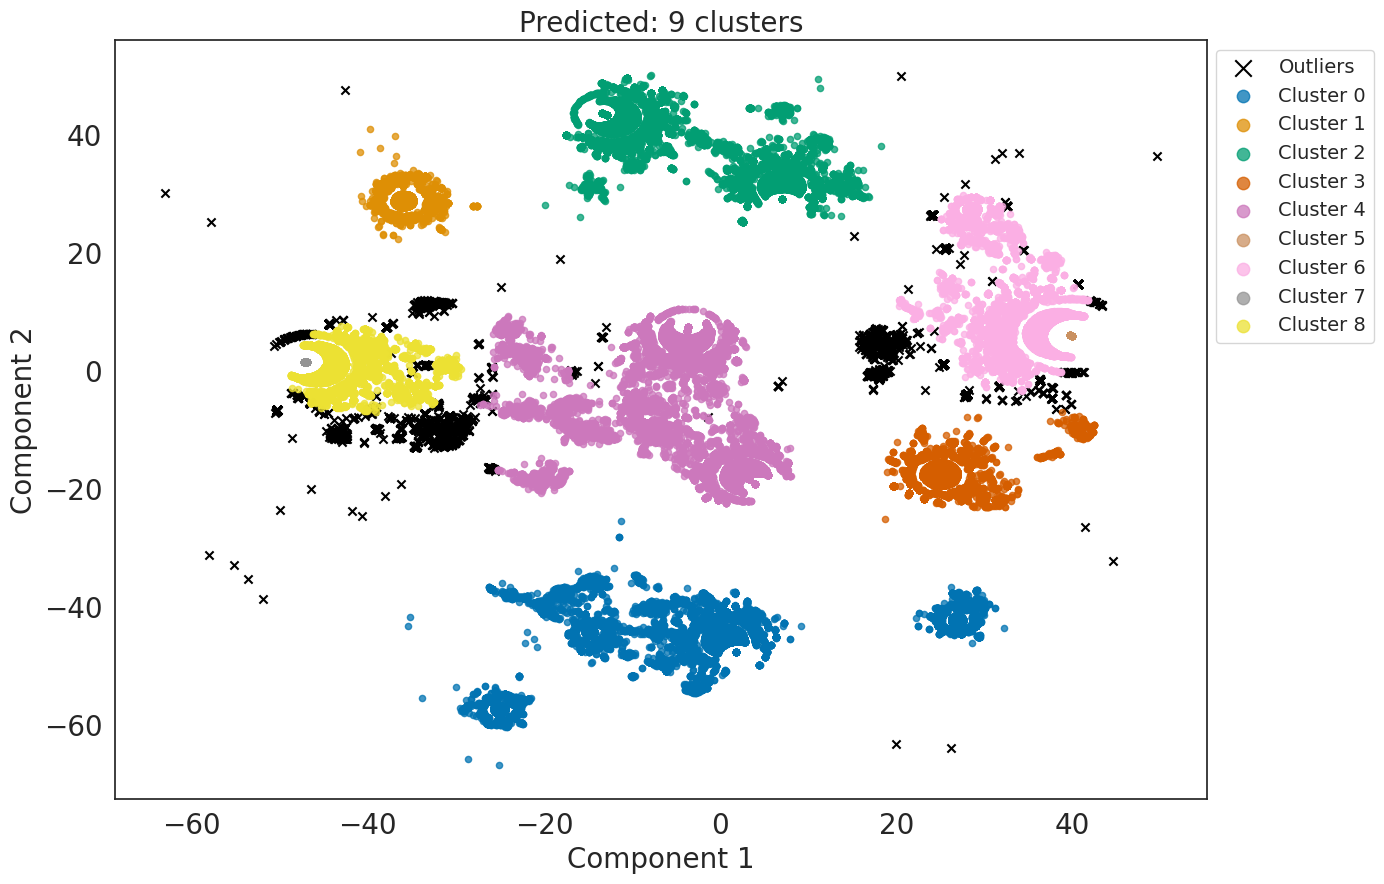

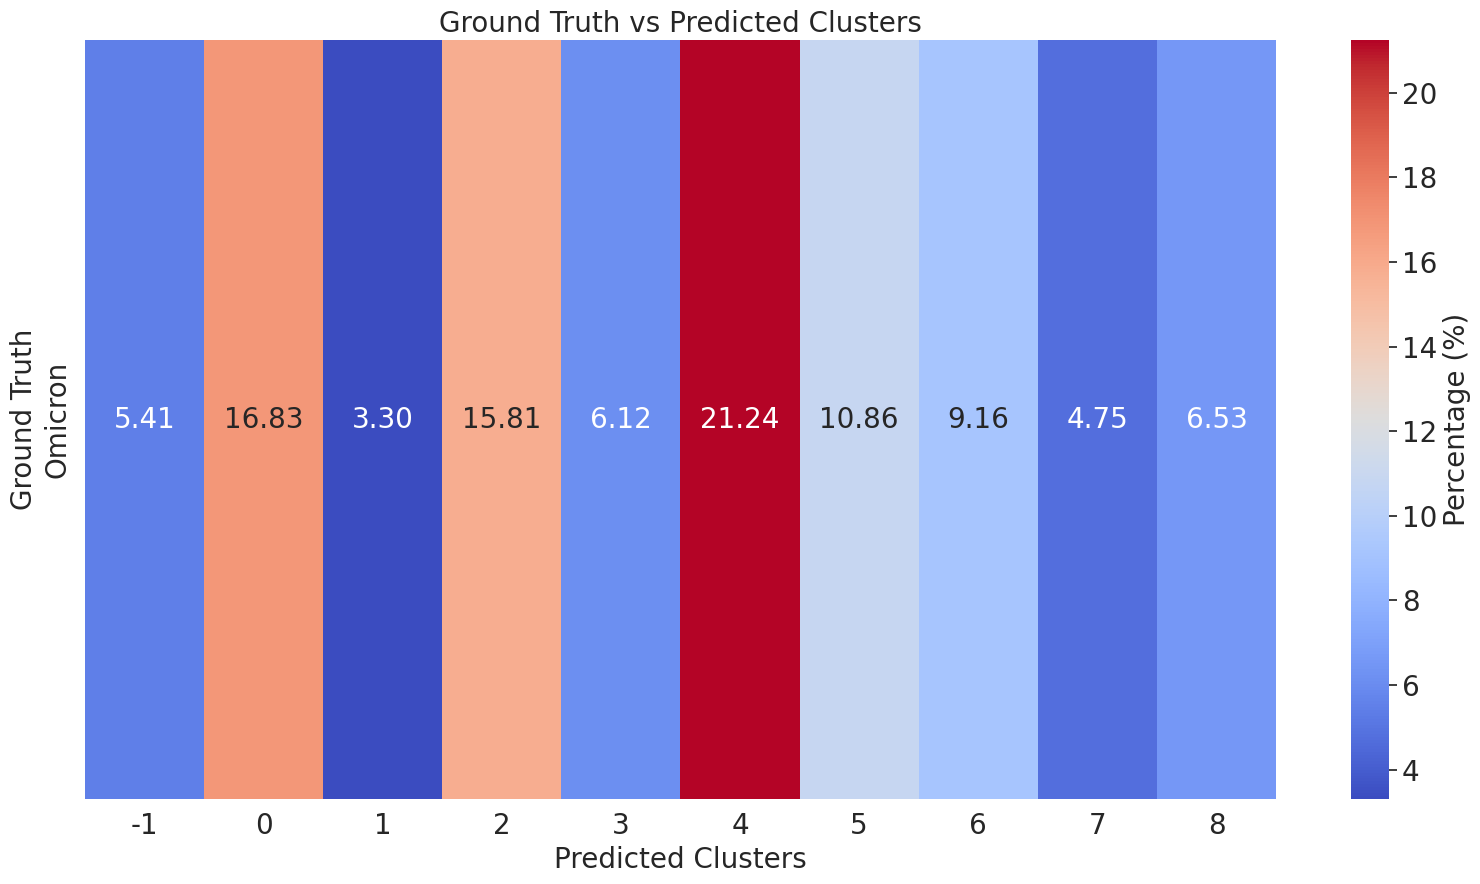

Predicted Clusters    -1      0     1      2     3      4      5      6     7  \
Ground Truth                                                                    
Omicron             8650  26932  5281  25299  9787  33984  17375  14663  7597   

Predicted Clusters      8  
Ground Truth               
Omicron             10448  
   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron          BA.2  22.867052  14.196512
1       -1  Omicron       BA.5.2*  11.075145   6.014943
2       -1  Omicron       BA.2.3*   7.063584  24.627166
3       -1  Omicron       BA.5.1*   6.242775   7.073618
4       -1  Omicron       BA.2.9*   4.485549  17.414722

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      XBB.1.5*  30.198277  99.632488
1        0  Omicron       CH.1.1*   9.702213  99.467073
2        0  Omicron       BN.1.3*   5.094312  99.061372
3        0  Omicron      BA.2.75*   4.470518  95.102686
4        0  Omicron         XBB.1   4.381405  99.578059

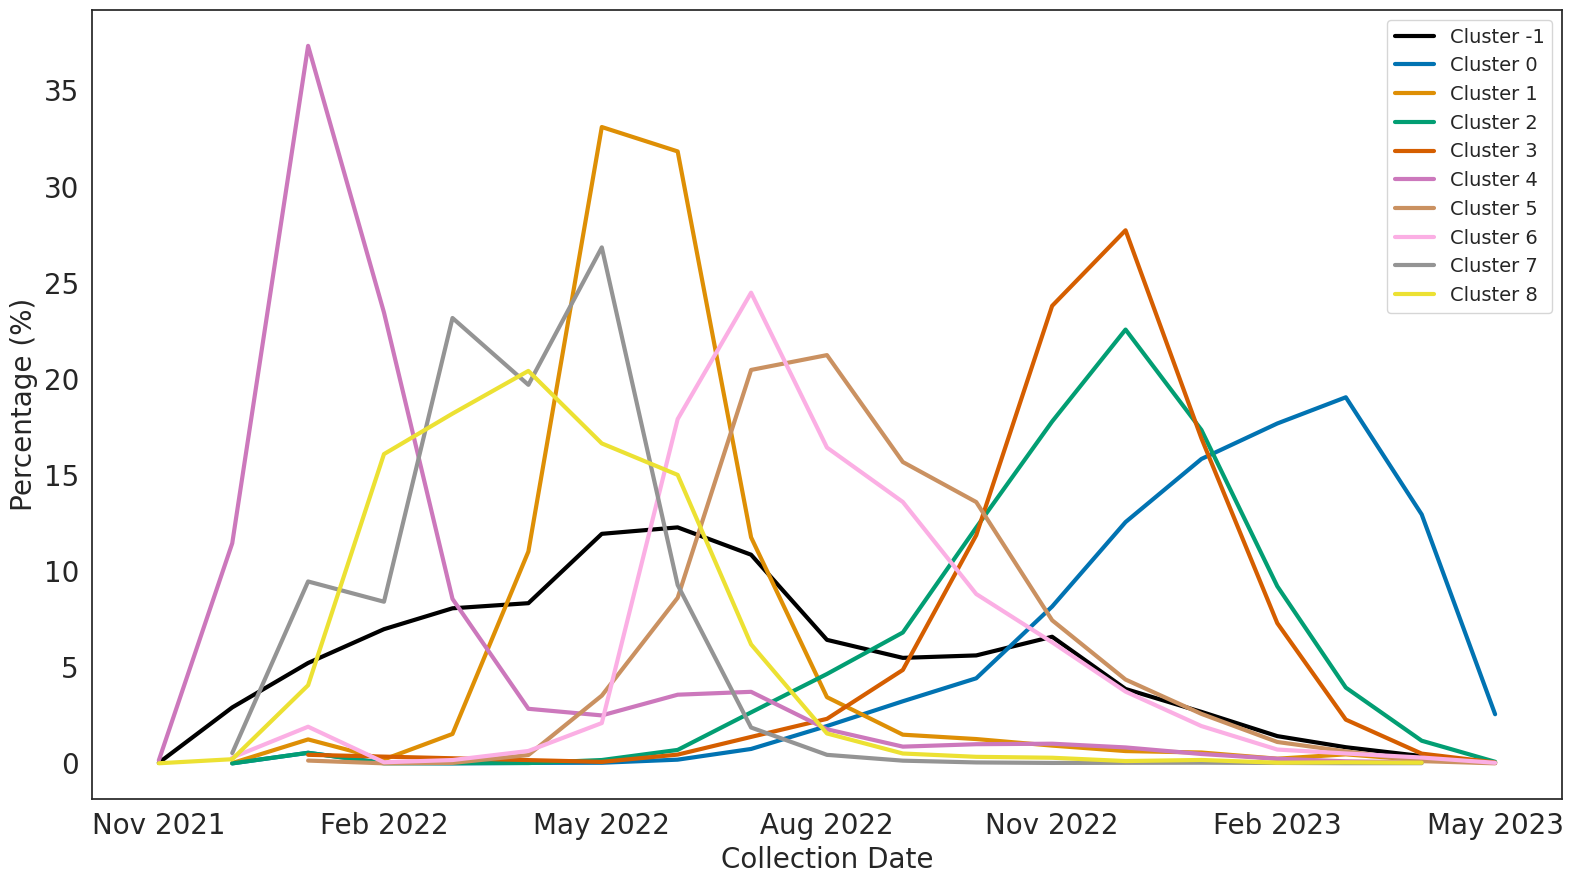

In [6]:
min_samples=250
min_cluster_size=5000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "colorblind")

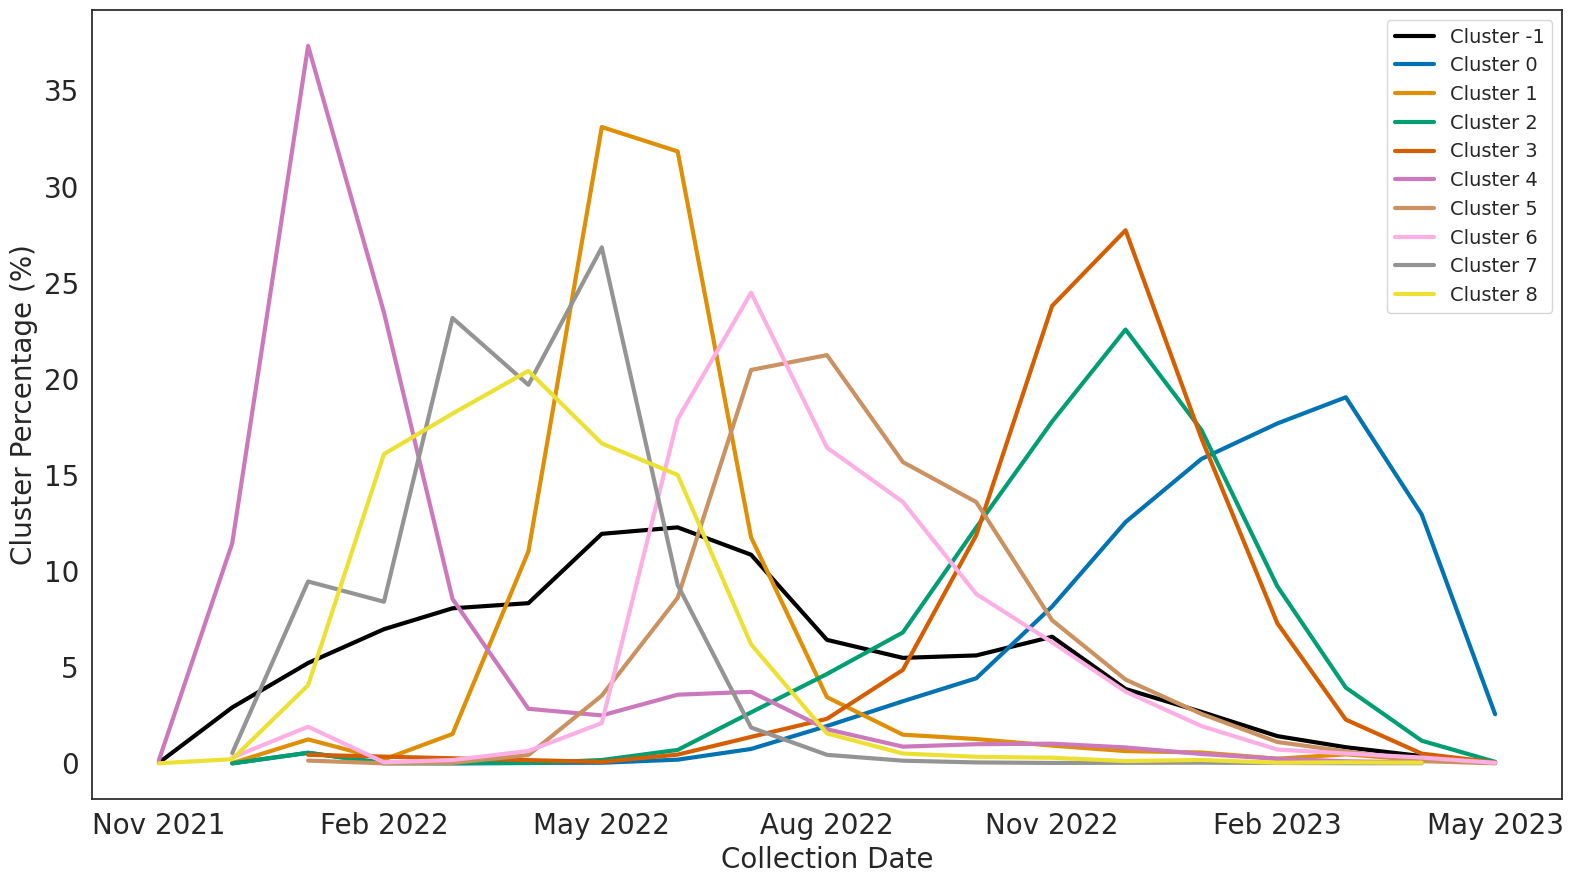

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

def cluster_date_collected(save_as, info_df, hdb_labels, colormap):
    """ Calculate variant percentages over collection dates within clusters and plot them in a single plot. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Define cluster color mapping, with outliers (Cluster -1) as black
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    # Ensure 'Collection date' is a datetime object
    df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

    # Aggregate data by counting variants for each collection date (by year and month)
    df['YearMonth'] = df['Collection date'].dt.to_period('M')
    cluster_date_counts = df.groupby(['Cluster', 'YearMonth', 'variant']).size().reset_index(name='Cluster count')

    # Calculate total count within each cluster
    total_cluster_count = df.groupby(['Cluster']).size().reset_index(name='Total count')
    cluster_date_counts = cluster_date_counts.merge(total_cluster_count, on='Cluster')

    # Calculate percentages within each cluster
    cluster_date_counts['Cluster %'] = (cluster_date_counts['Cluster count'] / cluster_date_counts['Total count']) * 100

    # Sort by 'Cluster' and 'YearMonth'
    cluster_date_counts = cluster_date_counts.sort_values(by=['Cluster', 'YearMonth'], ascending=[True, True])

    # Create a single plot with all clusters and variants
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot each cluster-variant pair in the same plot, applying color mapping
    for (cluster_label, variant), grouped_df in cluster_date_counts.groupby(['Cluster', 'variant']):
        ax.plot(grouped_df['YearMonth'].dt.to_timestamp(), 
                grouped_df['Cluster %'], 
                label=f"Cluster {cluster_label}",
                color=cluster_color_dict[cluster_label],  # Apply cluster-specific color
                linewidth=3)

    fontsize = 20
    ax.set_xlabel('Collection Date', fontsize=fontsize)
    ax.set_ylabel(f'Cluster Percentage (%)', fontsize=fontsize)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.legend(loc='upper right', fontsize=fontsize-6, bbox_to_anchor=(1, 1))

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".timescale.pdf", format="pdf")
    plt.savefig(save_as + ".timescale.png", format="png")
    plt.show()

cluster_date_collected(save_as, info_df, hdb_labels, "colorblind")

/tmp/ipykernel_2081385/2273347743.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


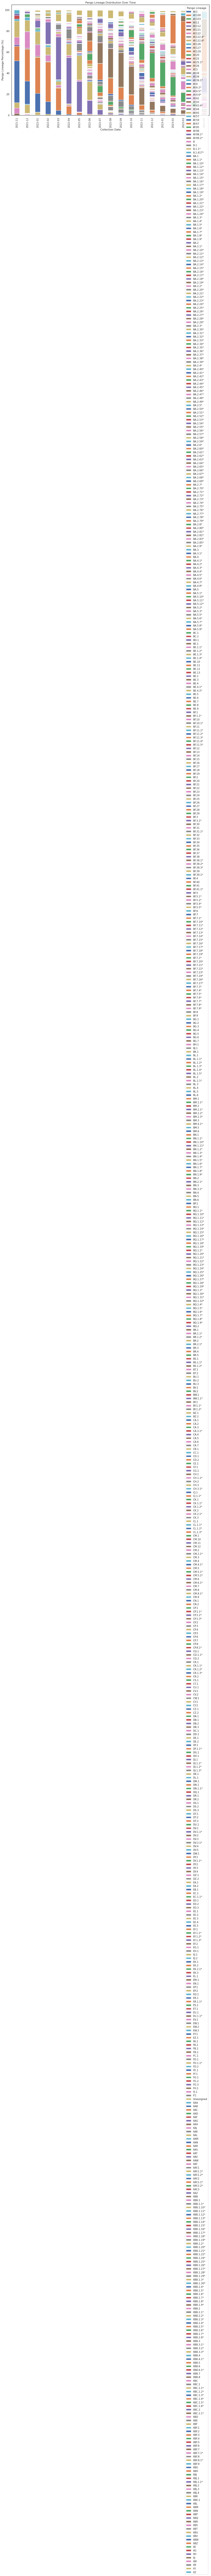

<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming info_df is already loaded and contains the necessary data
# Copy the DataFrame to avoid modifying the original
df = info_df.copy()

# Ensure 'Collection date' is a datetime object
df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

# Truncate Pango lineage to the first two parts if needed
trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

# Aggregate data by counting Pango lineage for each collection date (by year and month)
df['YearMonth'] = df['Collection date'].dt.to_period('M')
pango_lineage_counts = df.groupby(['YearMonth', 'Pango lineage']).size().reset_index(name='Pango count')

# Pivot the data for plotting
pango_lineage_pivot = pango_lineage_counts.pivot(index='YearMonth', columns='Pango lineage', values='Pango count')

# Calculate percentages
pango_lineage_percentages = pango_lineage_pivot.div(pango_lineage_pivot.sum(axis=1), axis=0) * 100

# Create a stacked bar chart
pango_lineage_percentages.plot(kind='bar', stacked=True, figsize=(16, 9))

# Set labels and title
plt.xlabel('Collection Date')
plt.ylabel('Pango Lineage Percentage (%)')
plt.title('Pango Lineage Distribution Over Time')
plt.legend(title='Pango Lineage', bbox_to_anchor=(1, 1), loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig("pango_lineage_distribution.pdf", format="pdf")
plt.savefig("pango_lineage_distribution.png", format="png")
